MLP mixer proposes a way to use just mlps for vision

Its not better but it is competetive (at large scale) and could be researched upon ->  due to speed of infernece
plus has better tolerence to pixel shuffling

It uses channel mixing and token mixing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

In [2]:
class MlpBlock(nn.Module):
    """
    Standard MLP block == two linear layers and a GELU nonlinearity.
    The first layer expands the dimension to mlp_dim, then shrinks back.
    fc-glu-fc
    """
    def __init__(self, in_features, mlp_dim):
        super(MlpBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, in_features)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

In [3]:
class MixerBlock(nn.Module):
    """
    A single Mixer block that separately mixes tokens and channels.
    It first applies token mixing (across patches) and then channel mixing (within features).
    part 1 then 2 in the arch diagram
    """
    def __init__(self, num_tokens, hidden_dim, tokens_mlp_dim, channels_mlp_dim,drop_path=0.1):
        super(MixerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(hidden_dim)
        # (1) MLP applied to the token dimension (each channel separately)
        self.token_mixing = MlpBlock(num_tokens, tokens_mlp_dim)

        self.norm2 = nn.LayerNorm(hidden_dim)
        # (2) MLP applied to the channel dimension (each token separately)
        self.channel_mixing = MlpBlock(hidden_dim, channels_mlp_dim)
        self.drop_path = drop_path


    # def forward(self, x):
    #     # x: (batch, num_tokens, hidden_dim)

    #     """
    #     # Token mixing
    #     """
    #     y = self.norm1(x)
    #     y = y.transpose(1, 2)  # (B, hidden_dim, num_tokens)
    #     y = self.token_mixing(y)
    #     y = y.transpose(1, 2)  # back to (B, num_tokens, hidden_dim)
    #     x = x + y  # skip connection
    #     """
    #     # Channel mixing
    #     """
    #     y = self.norm2(x)
    #     y = self.channel_mixing(y)
    #     return x + y  # skip connection

    def forward(self, x):
        # Token mixing
        if self.training and torch.rand(1).item() < self.drop_path:
            y = 0
        else:
            y = self.norm1(x)
            y = y.transpose(1, 2)
            y = self.token_mixing(y)
            y = y.transpose(1, 2)
            if self.drop_path > 0:
                y = y / (1 - self.drop_path)
        x = x + y

        # Channel mixing
        if self.training and torch.rand(1).item() < self.drop_path:
            y = 0
        else:
            y = self.norm2(x)
            y = self.channel_mixing(y)
            if self.drop_path > 0:
                y = y / (1 - self.drop_path)
        return x + y


In [4]:
class MlpMixer(nn.Module):
    """
    The full MLP-Mixer network.
    Given an input image, it splits it into patches via a convolution ("stem"),
    then processes the resulting tokens with several Mixer blocks,

    applies a final layer norm-> global average pooling-> linear classifier.

    Rn using CIFAR-100 (32×32 images), we set a small patch size (4×4) as imagent is too big
    """
    def __init__(self, num_classes, num_blocks, patch_size, hidden_dim,
                 tokens_mlp_dim, channels_mlp_dim, image_size=32, in_channels=3):
        super(MlpMixer, self).__init__()


        self.patch_size = patch_size
        """
        # (1) The stem Conv2d splits the image into non-overlapping patches.
        #     START OF THE PAPER WE SPLIT THE IMAGE INTO NON OVERLAPPING PATCH
        #     CNN does the same sort of thing
        """
        self.stem = nn.Conv2d(in_channels, hidden_dim, kernel_size=patch_size, stride=patch_size)
        self.num_tokens = (image_size // patch_size) ** 2


        """
        # (2) makes them into list of mixer block

        """
        # Create a list of Mixer blocks.
        self.mixer_blocks = nn.ModuleList([
            MixerBlock(num_tokens=self.num_tokens, hidden_dim=hidden_dim,
                       tokens_mlp_dim=tokens_mlp_dim, channels_mlp_dim=channels_mlp_dim)
            for _ in range(num_blocks)
        ])
        # Final layer normalization before classifiing
        self.norm = nn.LayerNorm(hidden_dim)

        # zero initialize the weights as in paper given
        self.head = nn.Linear(hidden_dim, num_classes)
        nn.init.zeros_(self.head.weight)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        # x: (batch, in_channels, image_size, image_size)
        x = self.stem(x)  # → (B, hidden_dim, H', W') where H' = image_size/patch_size
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # → (B, num_tokens, hidden_dim)
        for block in self.mixer_blocks:
            x = block(x)
        x = self.norm(x)
        x = x.mean(dim=1)  # global average pooling
        x = self.head(x)
        return x

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    avg_loss = running_loss / len(dataloader.dataset)
    return avg_loss

In [6]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [7]:

if __name__ == '__main__':
    # Data augmentation and normalization for training;
    # simple normalization for now , ask proff for better ones for smaller dataset/ larger
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                             std=[0.2675, 0.2565, 0.2761])
    ])
    """
    Images are normalized using mean and standard deviation
    Data Augmentation: Random Horizontal Flip
    """


    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                             std=[0.2675, 0.2565, 0.2761])
    ])

    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                             download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                            download=True, transform=transform_test)

    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader  = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 169M/169M [00:13<00:00, 12.5MB/s]


In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

if __name__ == '__main__':
    # Data augmentation and normalization for training;
    # Normalization values reused from CIFAR, consider tuning for STL10
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                             std=[0.2675, 0.2565, 0.2761])
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                             std=[0.2675, 0.2565, 0.2761])
    ])

    trainset = torchvision.datasets.STL10(root='./data', split='train',
                                          download=True, transform=transform_train)
    testset = torchvision.datasets.STL10(root='./data', split='test',
                                         download=True, transform=transform_test)

    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


100%|██████████| 2.64G/2.64G [04:21<00:00, 10.1MB/s]


In [9]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False
        self.verbose = verbose
        self.best_model = None

    def __call__(self, acc, model):
        if acc > self.best_acc:
            self.best_acc = acc
            self.best_model = model.state_dict()
            self.counter = 0
            if self.verbose:
                print(f"Validation accuracy improved to {acc:.4f}. Reset patience.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Patience counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


Starting training on STL10
Epoch [1/100], Loss: 2.2291, Test Accuracy: 16.85%, Train accuracy: 16.98
Epoch [2/100], Loss: 2.0968, Test Accuracy: 27.31%, Train accuracy: 27.14
Epoch [3/100], Loss: 1.9180, Test Accuracy: 30.69%, Train accuracy: 30.98
Epoch [4/100], Loss: 1.8505, Test Accuracy: 34.17%, Train accuracy: 35.30
Epoch [5/100], Loss: 1.7565, Test Accuracy: 36.40%, Train accuracy: 38.10
Epoch [6/100], Loss: 1.6639, Test Accuracy: 39.56%, Train accuracy: 42.48
Epoch [7/100], Loss: 1.6116, Test Accuracy: 37.35%, Train accuracy: 39.84
Epoch [8/100], Loss: 1.5553, Test Accuracy: 44.07%, Train accuracy: 48.82
Epoch [9/100], Loss: 1.4630, Test Accuracy: 46.88%, Train accuracy: 52.32
Epoch [10/100], Loss: 1.4061, Test Accuracy: 47.14%, Train accuracy: 54.40
Epoch [11/100], Loss: 1.4021, Test Accuracy: 47.08%, Train accuracy: 54.86
Epoch [12/100], Loss: 1.3245, Test Accuracy: 48.75%, Train accuracy: 58.64
Epoch [13/100], Loss: 1.3133, Test Accuracy: 47.62%, Train accuracy: 56.26
Epoch [

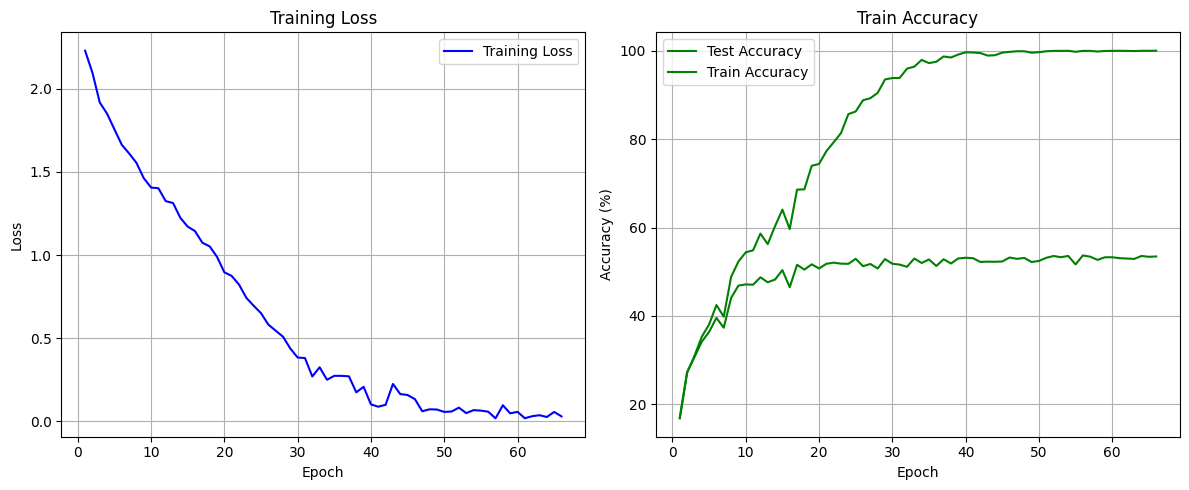

In [10]:
# --- Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import copy

# --- Model Setup (MlpMixer) ---
model = MlpMixer(
    num_classes=10,         # STL10 has 10 classes
    num_blocks=16,
    patch_size=8,           # 96 / 8 = 12 patches per dimension
    hidden_dim=256,
    tokens_mlp_dim=128,
    channels_mlp_dim=512,
    image_size=96,
    in_channels=3
)
model.to(device)

# --- Optimizer, Scheduler, Loss ---
optimizer = optim.AdamW(model.parameters(), lr=3e-3, weight_decay=0.05)
scheduler = CosineAnnealingLR(optimizer, T_max=100)
criterion = nn.CrossEntropyLoss()
num_epochs = 100

# --- Early Stopping ---
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.best_model = None
        self.early_stop = False

    def __call__(self, acc, model):
        if acc > self.best_acc:
            self.best_acc = acc
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=10)

# --- Metric Storage for Plotting ---
train_losses = []
train_accuracies=[]
test_accuracies = []

# --- Training Loop ---
print("Starting training on STL10")

for epoch in range(num_epochs):
    train_loss = train_epoch(model, trainloader, criterion, optimizer, device)
    train_acc = evaluate(model, trainloader, device)
    test_acc = evaluate(model, testloader, device)

    train_losses.append(train_loss)
    test_accuracies.append(test_acc)
    train_accuracies.append(train_acc)

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Test Accuracy: {test_acc * 100:.2f}%, Train accuracy: {train_acc*100:.2f}")

    early_stopping(test_acc, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# --- Load Best Model ---
model.load_state_dict(early_stopping.best_model)
print("Training complete :)")

# --- Plot Training Loss & Accuracy ---
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in test_accuracies], label='Test Accuracy', color='green')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

#train accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in train_accuracies], label='Train Accuracy', color='green')
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# --- Optional: Compare with Other Models ---
# Add other model accuracy lists if available
# Example:
# other_model_accuracies = {
#     "ResNet18": [0.62, 0.68, 0.71, ...],
#     "ViT": [0.58, 0.64, 0.70, ...],
#     "MlpMixer": test_accuracies
# }

# # Uncomment below to compare:
# plt.figure(figsize=(8, 6))
# for model_name, accs in other_model_accuracies.items():
#     plt.plot(range(1, len(accs)+1), [a * 100 for a in accs], label=model_name)
# plt.title("Model Accuracy Comparison")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy (%)")
# plt.grid(True)
# plt.legend()
# plt.show()
